<a href="https://colab.research.google.com/github/souhityac/Detectron-2-Object-Text-Detection/blob/main/Detectron_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

## Get data

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
!unzip dataset.zip

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


In [ ]:
!ls

sample_data


In [ ]:
import pandas as pd

df = pd.read_csv('dataset/train_labels.csv')

df

FileNotFoundError: ignored

In [ ]:
# Verifying image shape (width x height)
print(df['width'].min(), df['width'].max())
print(df['height'].min(), df['height'].max())


## Register data-set

In order to use a dataset with Detectron2 we need to register it. 


In [ ]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

# write a function that loads the dataset into detectron2's standard format
def get_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['filename'].map(lambda x: img_dir+x)

    classes = ['Section Title', 'Section Text', 'Section No.', 'Page No.']
    #print(df['class'].unique())
    #classes = ['Raspberry_Pi_3', 'Arduino_Nano', 'ESP8266', 'Heltec_ESP32_Lora']

    df['class_int'] = df['class'].map(lambda x: classes.index(x))
    

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['Section Title', 'Section Text', 'Section No.', 'Page No.']

for d in ["train", "test"]:
  DatasetCatalog.register('docdet7/' + d, lambda d=d: get_dicts('dataset/' + d + '_labels.csv', 'dataset/' + d +'/'))
  MetadataCatalog.get('docdet7/' + d).set(thing_classes=classes)
docdet_metadata = MetadataCatalog.get('docdet7/train')

We can check if our code works correctly by plotting a few images.

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('docdet7/train')
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=docdet_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Train model

Now, let's fine-tune a pretrained FasterRCNN object detection model to detect the different microcontrollers.

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('docdet7/train',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ('docdet7/test', )
predictor = DefaultPredictor(cfg)

In [91]:
df_test = pd.read_csv('dataset/test_labels.csv')
df_test

,filename,width,height,class,xmin,ymin,xmax,ymax
0,8.png,499,647,Section Text,114,48,447,211
1,8.png,499,647,Section Text,115,298,451,476
2,8.png,499,647,Section Text,113,544,454,592
3,8.png,499,647,Section Text,114,243,450,270
4,8.png,499,647,Section Title,114,520,326,536
...,...,...,...,...,...,...,...,...
140,1.png,499,647,Section Title,113,387,178,402
141,1.png,499,647,Section No.,68,209,94,225
142,1.png,499,647,Section No.,67,292,93,308
143,1.png,499,647,Section No.,67,385,93,401


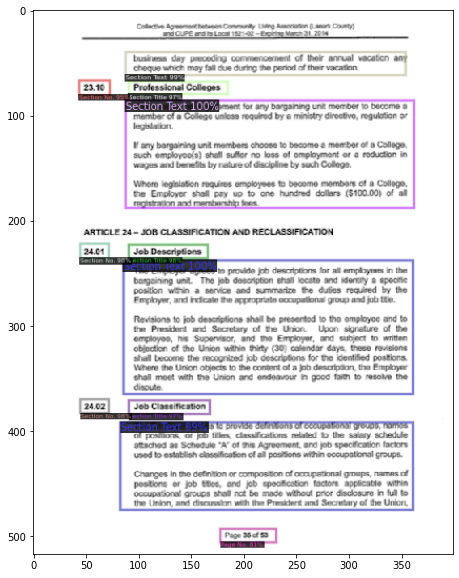

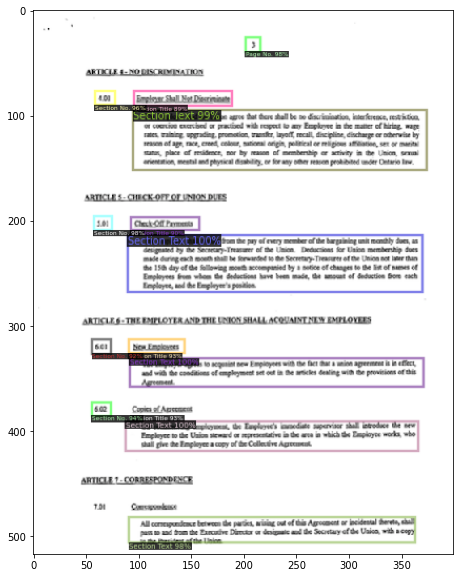

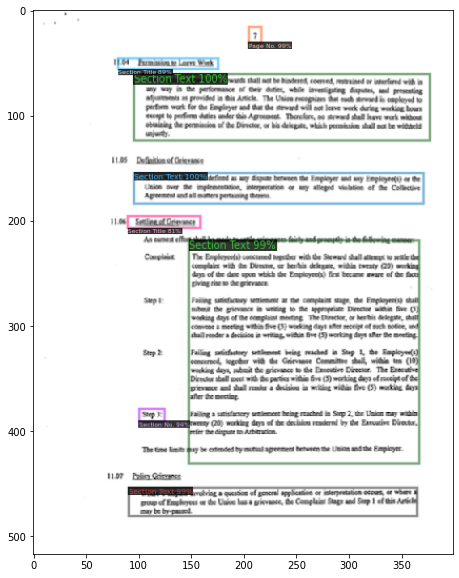

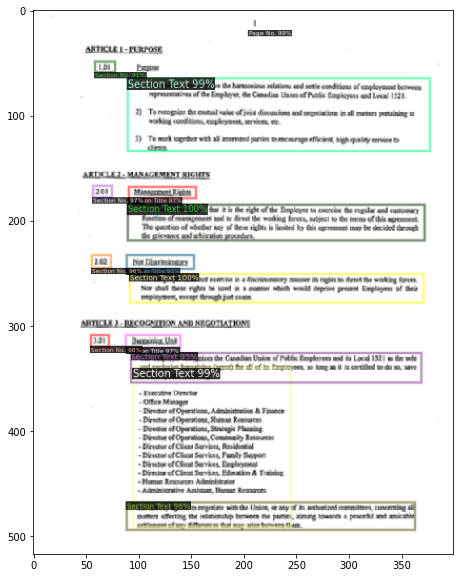

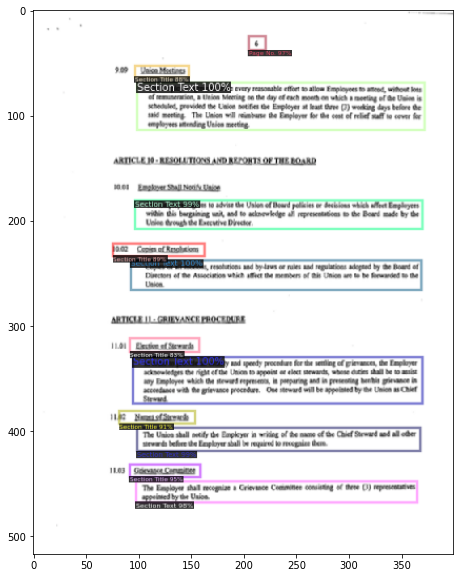

In [92]:
from detectron2.utils.visualizer import ColorMode
import random

bb_list = []
dataset_dicts = DatasetCatalog.get('docdet7/test')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=docdet_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    bb_list.append(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [93]:
roi_list = []
sample_bb = bb_list[0].pred_boxes
for i in range(len(sample_bb)):
  this_box = sample_bb.__getitem__(i).tensor
  temp = [this_box[0][j].item() for j in range(len(this_box[0]))]
  roi_list.append(temp)
    


In [94]:
roi_list

[[109.86763000488281,
  108.36517333984375,
  452.0555114746094,
  235.3206024169922],
 [107.4227523803711, 298.216064453125, 450.6949768066406, 456.9167785644531],
 [104.17524719238281, 490.2801513671875, 451.2268981933594, 595.0787963867188],
 [109.50666809082031, 50.91463088989258, 442.9328308105469, 78.0129165649414],
 [56.79218292236328, 463.1889343261719, 90.44829559326172, 479.9242248535156],
 [56.21950149536133, 278.8492126464844, 89.84521484375, 295.60711669921875],
 [113.7734375, 279.7372741699219, 207.0270233154297, 295.2721862792969],
 [114.01751708984375,
  464.4141845703125,
  210.36660766601562,
  480.6017761230469],
 [113.23117065429688, 86.0431900024414, 230.74325561523438, 100.7656478881836],
 [54.67564010620117, 84.90122985839844, 91.14225769042969, 101.55339050292969],
 [223.0718536376953, 617.3104248046875, 289.2555847167969, 632.9420166015625]]